In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

### Lettura dataset e selezione dei soli giocatori in entrata (evitando così doppi trasferimenti e giocatori svincolati)

In [9]:
df = pd.read_csv('./dataset/dataset/transfers.csv')
dataset = df[df['dir'] == 'in']
dataset

,league,season,window,team_id,team_name,team_country,dir,player_id,player_name,player_age,...,counter_team_id,counter_team_name,counter_team_country,transfer_fee_amnt,market_val_amnt,is_free,is_loan,is_loan_end,is_retired,transfer_id
0,GB1,2009,s,985,Manchester United,England,in,33544,Antonio Valencia,23.0,...,1071,Wigan Athletic,England,18800000.0,NaN,False,False,False,False,310832
1,GB1,2009,s,985,Manchester United,England,in,62049,Mame Diouf,21.0,...,687,Molde FK,Norway,4500000.0,1600000.0,False,False,False,False,319841
2,GB1,2009,s,985,Manchester United,England,in,43261,Gabriel Obertan,20.0,...,40,FC Girondins Bordeaux,France,4000000.0,400000.0,False,False,False,False,315185
3,GB1,2009,s,985,Manchester United,England,in,1397,Michael Owen,29.0,...,762,Newcastle United,England,0.0,NaN,True,False,False,False,306421
4,GB1,2009,s,985,Manchester United,England,in,73538,Scott Moffatt,18.0,...,5242,Manchester United U18,England,NaN,NaN,False,False,False,False,339015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70000,NL1,2021,w,385,Fortuna Sittard,Netherlands,in,140032,Andreas Samaris,32.0,...,515,Without Club,Without Club,NaN,1500000.0,False,False,False,False,3633188
70001,NL1,2021,w,306,SC Heerenveen,Netherlands,in,257808,Runar Espejord,25.0,...,1293,Tromsø IL,Norway,NaN,500000.0,False,True,True,False,3071862
70002,NL1,2021,w,306,SC Heerenveen,Netherlands,in,580142,Joaquín Fernández,22.0,...,37535,Montevideo City Torque,Uruguay,NaN,100000.0,False,True,True,False,3268245
70003,NL1,2021,w,468,Sparta Rotterdam,Netherlands,in,340353,Maduka Okoye,22.0,...,1010,Watford FC,England,NaN,1000000.0,False,True,False,False,3619917


In [7]:
print('colonna player_age Nan -> ' , dataset['player_age'].isna().sum())
print('colonna transfer_fee_amnt Nan -> ' , dataset['transfer_fee_amnt'].isna().sum())
print('colonna market_val_amnt Nan -> ' , dataset['market_val_amnt'].isna().sum())
print('colonna team_name Nan -> ' , dataset['team_name'].isna().sum())
print('colonna counter_team_name Nan -> ' , dataset['counter_team_name'].isna().sum())
retired_rows = dataset[(dataset['team_id'] == 'Retired') | (dataset['counter_team_id'] == 'Retired')]
print('colonne team_id o counter_team_id Retired -> ', retired_rows.shape[0])
print('Numero di campioni in cui la colonna is_loan_ended è True ->', (dataset['is_loan_end'] == True).sum())

colonna player_age Nan ->  6
colonna transfer_fee_amnt Nan ->  18669
colonna market_val_amnt Nan ->  7523
colonna team_name Nan ->  0
colonna counter_team_name Nan ->  0
colonne team_id o counter_team_id Retired ->  2
Numero di campioni in cui la colonna is_loan_ended è True -> 8719


### Preprocessing:
##### - Rimuoviamo i 6 trasferimenti il cui player_age è Nan (per eventuali analisi future sull'età)
##### - Sostituiamo i Nan di transfer_fee_amnt con 0 (per eventuali analisi future sui valori di trasferimento)
##### - Sostituiamo i Nan di market_val_amnt con 0 (per eventuali analisi future sui valori di mercato)
##### - Seleziono solo i trasferimenti in cui la colonna 'counter_team_name' è diversa da 'Without Club' in quanto questa indica giocatori svincolati
##### - Seleziono solo i trasferimenti in cui la colonna 'team_name' è diversa da 'Without Club' in quanto questa indica l'ingaggio di giocatori svincolati
#### - Rimuovo le righe in cui è presente in Counter_team_id e counter_team_name la parola Retired (ritirato)

In [12]:
# rimuovi i 6 player che non hanno età
dataset.dropna(subset=['player_age'], inplace=True)
# sostituisci i valori di trasferimento Nan con 0
dataset['transfer_fee_amnt'].fillna(0, inplace=True)
# sostituisci i valori di valore di mercato Nan con 0
dataset['market_val_amnt'].fillna(0, inplace=True)
# rimuovi i trasferimenti senza squadra di destinazione (ovvero svincoli)
dataset = dataset[dataset['counter_team_name'] != 'Without Club'] 
# rimuovi i trasferimenti senza squadra di provenienza (ovvero ingaggio di svincolati)
dataset = dataset[dataset['team_name'] != 'Without Club']
# Rimuovi le righe in cui 'team_id' o 'counter_team_id' sono uguali a 'Retired'
dataset = dataset[(dataset['team_id'] != 'Retired') & (dataset['counter_team_id'] != 'Retired')]
# Rimozione dei rientri dal prestito (is_loan_end = True)
dataset = dataset[dataset['is_loan_end'] == False]

# Conversione dei valori di 'team_id' e 'counter_team_id' in interi
dataset['team_id'] = dataset['team_id'].astype(int)
dataset['counter_team_id'] = dataset['counter_team_id'].astype(int)


print('Il dataset è composto da ', dataset.shape[0], ' trasferimenti')

Il dataset è composto da  22696  trasferimenti


### Inizio costruzione della rete
#### Ogni team deve avere:
##### - un id
##### - un nome
##### - un paese e un codice lega (GB1 ad esempio)
### I team devono essere presi sia da team_name che da counter_team_name
#### Ogni trasferimento deve avere: 
##### - un id di trasferimento (?)
##### - un player id 
##### - un player name
##### - l'età del player
##### - una season
##### - una finestra di mercato (invernale o estiva)
##### - un valore di trasferimento
##### - un bool che indica se è in prestito o a titolo definitivo
##### - il valore di mercato (?)

In [13]:
G = nx.MultiDiGraph()

for index, row in dataset.iterrows():
    player_name = row['player_name']
    
    # Utilizza l'ID della squadra come identificatore del nodo
    team1 = row['team_id']
    team2 = row['counter_team_id']
    
    if not G.has_node(team1):
        G.add_node(team1, label='team', name=row['team_name'], country=row['team_country'])
    if not G.has_node(team2):
        G.add_node(team2, label='team', name=row['counter_team_name'], country=row['counter_team_country'])
    
    transfer_attributes = {
        'transfer_id': row['transfer_id'],
        'player_id': row['player_id'],
        'player_name': row['player_name'],
        'player_age': row['player_age'],
        'season': row['season'],
        'window': row['window'],
        'transfer_fee_amnt': row['transfer_fee_amnt'],
        'is_loan': row['is_loan'],
        'market_val_amnt': row['market_val_amnt']
    }
    
    G.add_edge(team2, team1, label='transfer', **transfer_attributes) 

print('Numero di nodi:', G.number_of_nodes())
print('Numero di archi:', G.number_of_edges())


Numero di nodi: 2193
Numero di archi: 22696


" \n    # Calcola il grado dei nodi in ingresso e in uscita\n    in_degree = G.in_degree()\n    out_degree = G.out_degree()\n\n    # Stampa il numero di archi entranti e uscenti del nodo 'FC Internazionale'\n    node = 46\n    print(f'Nodo {node}: Archi entranti = {in_degree[node]}, Archi uscenti = {out_degree[node]}')\n    print(G.nodes[node])\n"

In [14]:
print('Nodi -> ', G.number_of_nodes())
print('Archi -> ', G.number_of_edges())
print('Density -> ', nx.density(G))

Nodi ->  2193
Archi ->  22696
Density ->  0.00472139288579122


Uno dei problemi che spesso si presenta in questa disciplina è l'esplosione delle reti, che sorge quando la rete cresce rapidamente in dimensioni e complessità a causa dell'aggiunta di nuovi nodi o archi. 
Questo fenomeno può influenzare notevolmente l'accuratezza e la significatività dei risultati ottenuti attraverso l'analisi delle reti.
### Seleziona solo i nodi che hanno almeno 10 archi in totale tra ingresso e uscita



In [15]:
# Calcola il grado dei nodi in ingresso e in uscita
in_degree = G.in_degree()
out_degree = G.out_degree()

# Crea un elenco dei nodi (team) che soddisfano il criterio di avere almeno 50 archi in totale tra ingresso e uscita
selected_teams = [node for node in G.nodes() if (in_degree[node] + out_degree[node]) >= 10]

print('Nodi selezionati -> ', len(selected_teams), ' nodi con almeno 10 operazioni di mercato')

# Crea un nuovo grafo (sottografo) basato sui nodi selezionati
net = G.subgraph(selected_teams)

net = net.copy()

# Identifica i nodi che soddisfano il criterio (transfer_fee_amnt uguale a 0 per tutti gli archi uscenti e entranti)
nodes_to_remove = []
for node in net.nodes():
    out_edges = net.out_edges(node, data=True)
    in_edges = net.in_edges(node, data=True)
        
    if all(attr['transfer_fee_amnt'] == 0 for _, _, attr in out_edges) and all(attr['transfer_fee_amnt'] == 0 for _, _, attr in in_edges):
        nodes_to_remove.append(node)

print('Nodi da rimuovere -> ', len(nodes_to_remove), ' nodi con tutte le operazioni di mercato a 0')

net.remove_nodes_from(nodes_to_remove)

print('Nodi -> ', net.number_of_nodes())
print('Archi -> ', net.number_of_edges())
print('Density -> ', nx.density(net))

Nodi selezionati ->  556  nodi con almeno 10 operazioni di mercato
Nodi da rimuovere ->  114  nodi con tutte le operazioni di mercato a 0
Nodi ->  442
Archi ->  16371
Density ->  0.08398744113029827


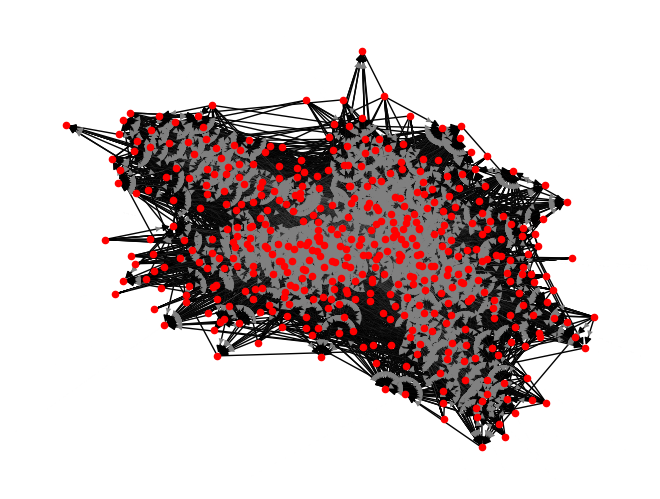

In [64]:
# Disegna il grafo
pos = nx.spring_layout(net)  # Posiziona i nodi in modo che siano ben distribuiti

# Disegna i nodi senza etichette
nx.draw(net, pos, with_labels=False, node_size=20, node_color='red')

# Disegna gli archi
nx.draw_networkx_edges(net, pos, width=0.02, edge_color='gray')

# Mostra il grafico
plt.axis('off')  # Nasconde gli assi
plt.show()

## Misure: grado di centralità 
#### Misura il numero di connessioni in entrata e in uscita da un nodo all'interno della rete. I nodi con un grado di centralità più elevato sono considerati più importanti all'interno della rete poichè hanno più connessioni con altri nodi. Nel nostro caso può essere utilizzata per identificare quelli che sono i club più attivi e influenti nel calciomercato dal 2009 al 2021 così come quelli meno attivi. In particolare vengono identificati:
#### - I nodi più importanti della rete -> maggior numero di connessioni con gli altri nodi. Indicano club più attivi e influenti.
#### - I nodi di confine -> minor numero di connessioni. Indicano i club meno influenti nel calciomercato
#### - Comunità -> la centralità di grado può essere utilizzata per identificare comunità di club. Le comunità sono gruppi di nodi altamente connessi tra loro e con meno connessioni ai nodi esterni al gruppo. Nel nostro caso può aiutare a identificare gruppi di club tra cui sono avvenuti molti trasferimenti nel periodo preso in esame. 

In [47]:
# Cerca i club con il maggior numero di trasferimenti (senza utilizzare la rete)
'''
# Raggruppa i dati per squadra e conta i trasferimenti
team_transfers_count = dataset['team_name'].value_counts()

# Trova le prime 10 squadre con il maggior numero di trasferimenti
top_10_teams = team_transfers_count.head(10)

print("Le prime 10 squadre con il maggior numero di trasferimenti:")
print(top_10_teams)

'''

# Calcola il grado di centralità di tutti i nodi
degree_centrality = nx.degree_centrality(G)

# Ordina i nodi in base alla centralità di grado in ordine decrescente
sorted_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Seleziona i primi 10 club più influenti / attivi
top_10_clubs = sorted_nodes[:10]

# Seleziona gli ultimi 10 club meno influenti / meno attivi
bottom_10_clubs = sorted_nodes[-10:]

# Stampa i risultati
print("I 10 club più influenti:")
for club, centrality in top_10_clubs:
    club_id = club
    club_name = G.nodes[club]['name']
    print("ID del club:", club_id, " - Nome del club:", club_name, " - Centralità di grado:", centrality)

print("\nI 10 club meno influenti:")
for club, centrality in bottom_10_clubs:
    club_id = club
    club_name = G.nodes[club]['name']
    print("ID del club:", club_id, " - Nome del club:", club_name, " - Centralità di grado:", centrality)


I 10 club più influenti:
ID del club: 252  - Nome del club: Genoa CFC  - Centralità di grado: 0.2614051094890511
ID del club: 130  - Nome del club: Parma Calcio 1913  - Centralità di grado: 0.22445255474452555
ID del club: 46  - Nome del club: FC Internazionale  - Centralità di grado: 0.19297445255474452
ID del club: 12  - Nome del club: AS Roma  - Centralità di grado: 0.17883211678832117
ID del club: 506  - Nome del club: Juventus FC  - Centralità di grado: 0.17883211678832117
ID del club: 294  - Nome del club: SL Benfica  - Centralità di grado: 0.17563868613138686
ID del club: 410  - Nome del club: Udinese Calcio  - Centralità di grado: 0.1738138686131387
ID del club: 720  - Nome del club: FC Porto  - Centralità di grado: 0.16605839416058393
ID del club: 1075  - Nome del club: SC Braga  - Centralità di grado: 0.16423357664233576
ID del club: 430  - Nome del club: ACF Fiorentina  - Centralità di grado: 0.16377737226277372

I 10 club meno influenti:
ID del club: 21379  - Nome del club:

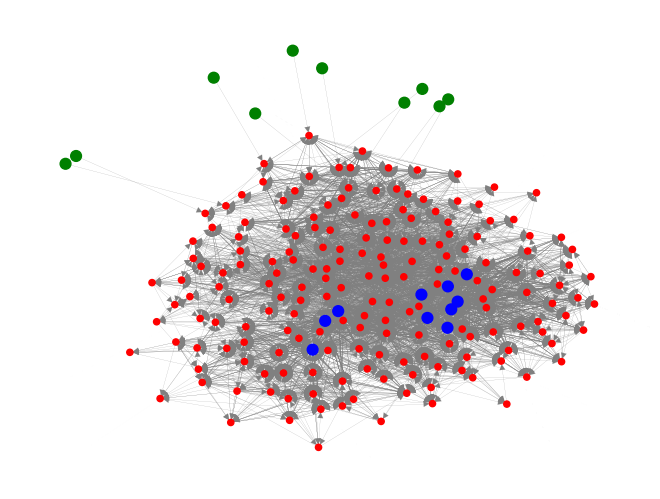

In [62]:
# Nodi più influenti e nodi meno influenti (di confine)

# Seleziona i nodi top 10 e bottom 10 insieme ai loro vicini
selected_nodes = [node for node, _ in top_10_clubs] + [node for node, _ in bottom_10_clubs]
subgraph = G.subgraph(selected_nodes)

# Estrai il sottografo completo che include tutti i nodi collegati ai nodi selezionati
full_subgraph = G.subgraph(list(subgraph.nodes) + [edge[1] for edge in G.edges(subgraph.nodes)])

# Crea una mappa di colori per i nodi
node_colors = []
node_sizes = []
for node in full_subgraph.nodes:
    if node in [club for club, _ in top_10_clubs]:
        node_colors.append('blue')  # Nodi top 10
        node_sizes.append(60)  # Dimensione più grande per i nodi blu
    elif node in [club for club, _ in bottom_10_clubs]:
        node_colors.append('green')  # Nodi bottom 10
        node_sizes.append(60)  # Dimensione più grande per i nodi verdi
    else:
        node_colors.append('red')  # Altri nodi
        node_sizes.append(20)  # Dimensione più piccola per i nodi rossi

# Disegna il grafo completo
pos = nx.kamada_kawai_layout(full_subgraph)
nx.draw(full_subgraph, pos, node_color=node_colors, with_labels=False, node_size=node_sizes, edge_color='gray', width=0.1)

# Visualizza il grafo
plt.show()
